# Home Credit Solution 

# 1. Introduction
The objective of this project is to use historical loan application data to predict whether or not an applicant will be able to repay a loan.

# 2. Importing requires packages

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
import gc
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Retrieving the Data

In [2]:
# List files available
print(os.listdir("../input/"))

['bureau_balance.csv', 'application_test.csv', 'installments_payments.csv', 'application_train.csv', 'POS_CASH_balance.csv', 'sample_submission.csv', 'bureau.csv', 'credit_card_balance.csv', 'previous_application.csv']


# 4. Exploration of Application Train/Test Data.

In [3]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')
print('Training data shape: {}, Testing data shape: {}'.format( app_train.shape,app_test.shape))

Training data shape: (307511, 122), Testing data shape: (48744, 121)


## 4.1 Merge both train and test dataset

In [4]:
df = app_train
df = df.append(app_test)
df.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,...,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,176307.000000,176307.000000,176307.000000,148671.000000,148671.000000,148671.000000,356255.000000,356253.000000,107895.000000,107895.000000,107895.000000,356255.000000,356255.000000,356255.000000,356254.000000,356255.000000,355205.000000,355205.000000,167175.000000,167175.000000,167175.000000,177848.000000,177848.000000,177848.000000,162345.000000,3.555870e+05,286622.000000,356255.000000,356255.000000,356255.000000,...,115147.000000,115147.000000,115147.000000,356255.000000,145411.000000,145411.000000,145411.000000,356255.000000,356255.000000,113276.000000,113276.000000,113276.000000,178353.000000,178353.000000,178353.000000,109394.000000,109394.000000,109394.000000,160489.000000,160489.000000,160489.000000,355205.000000,355205.000000,121014.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,307511.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,0.118138,0.118549,0.114914,0.088673,0.088178,0.087750,0.414316,2.151858,0.045045,0.044994,0.042930,-16041.248841,64317.231413,-3002.071163,-978.580852,-4983.593527,0.143452,0.100198,0.079819,0.078930,0.075346,0.150015,0.149494,0.145471,0.501965,5.148900e-01,0.509350,0.998170,0.000020,0.003537,...,0.232817,0.232504,0.228878,12.055749,0.066454,0.067296,0.065092,0.178824,0.040847,0.101495,0.102674,0.106382,0.108089,0.109279,0.106641,0.008868,0.008697,0.008116,0.028503,0.028386,0.027183,1.425729,1.409468,12.023741,0.020917,2.050506,2.028932,0.078076,0.229661,0.015649,0.051371,278128.000000,0.080729,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,0.108954,0.109824,0.108745,0.082312,0.082017,0.084076,0.720378,0.907937,0.077045,0.077140,0.075437,4358.803980,141705.532576,1517.901735,835.063902,3526.968986,0.456579,0.368259,0.135249,0.135133,0.133025,0.100139,0.100450,0.101088,0.210045,1.897531e-01,0.194141,0.042741,0.004433,0.059366,...,0.161909,0.162419,0.161725,3.267576,0.081287,0.082267,0.081911,0.383206,0.197936,0.093418,0.094541,0.098779,0.111194,0.112881,0.112555,0.047876,0.047519,0.046330,0.069880,0.07057

We can see there are some anamolies in  `DAYS_EMPLOYED`.

`DAYS_EMPLOYED` at max seems to have very large positive value.


## 4.2 Removing Anamolies / Outlier
In statistics, an outlier is an observation point that is distant from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error; the latter are sometimes excluded from the data set. An outlier can cause serious problems in statistical analyses.




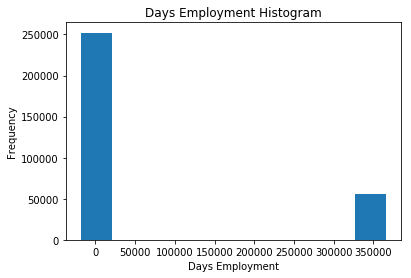

In [5]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

365243 days is somewhat around 1000 years, which is impossible.

So, its best for us to replace it by NaN.

In [6]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

## 4.3 Categorical Variables 

In [7]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

`CODE_GENDER` has unknown value 'XNA'. Its better to remove these 4 rows.

In [8]:
print (df['CODE_GENDER'].value_counts())

# Remove the rows with XNA value in CODE_GENDER
print ('\nSize Before {}'.format(df.shape))
df = df[df['CODE_GENDER'] != 'XNA']
print ('Size After {}'.format(df.shape))

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

Size Before (356255, 122)
Size After (356251, 122)


## 4.4 Label Encoder and One Hot Encoding

**Label Encoder **: As you might know by now, we can’t have text in our data if we’re going to run any kind of model on it. So before we can run a model, we need to make this data ready for the model.

And to convert this kind of categorical text data into model-understandable numerical data, we use the Label Encoder class.

Suppose, we have a feature State which has 3 category i.e India , France, China . So, Label Encoder will categorize them as 0, 1, 2.

**One Hot Encoding** : One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. 

If we applied OHE on say Gender column which has category male,female. OHE will create two new column Gender_male, Gender_female and store the value 0 and 1 according to the main category value.

In [9]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print ('{} variable are label encoded'.format(le_count))


# One Hot Encoding 
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
df = pd.get_dummies(df, columns= categorical_columns, dummy_na= True)
print ('The shape of dataset after One hot encoding: {}'.format(df.shape))

4 variable are label encoded
The shape of dataset after One hot encoding: (356251, 253)


## 4.5 Add some feature variables
Since i don't consider myself as a credit expert. I have used this features from [this](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features/code#L261) script by Aguiar.

- DAYS_EMPLOYED_PERC: the percentage of the days employed relative to the client's age.
- INCOME_CREDIT_PERC: the percentage of the credit amount relative to a client's income.
- INCOME_PER_PERSON : the percentage of income per person.
- ANNUITY_INCOME_PERC: the percentage of the loan annuity relative to a client's income.
- PAYMENT_RATE : the percentage of rate of payment annually.

In [10]:
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

## Target Column Distribution 
The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [11]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

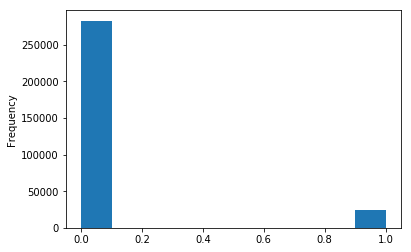

In [12]:
app_train['TARGET'].astype(int).plot.hist();

There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

## Garbage Collection
Python’s memory allocation and deallocation method is automatic. The user does not have to preallocate or deallocate memory similar to using dynamic memory allocation in languages such as C or C++.

Here we are using **Manual Garbage Collection**

Invoking the garbage collector manually during the execution of a program can be a good idea on how to handle memory being consumed by reference cycles.
The garbage collection can be invoked manually in the following way:

In [13]:
del app_test, app_train
gc.collect()

2650

If you wish not to use GC then better watch your RAM. It is likely to over-exceed and Kernel error may come up.

## Handling Categorical Features

In [14]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

In [15]:
# # factorize the categorical features from train and test data
# df_cats = _get_categorical_features(df)
# df = _factorize_categoricals(df, df_cats)

# 5. Exploration of Bureau and Bureau_data

In [16]:
bureau = pd.read_csv('../input/bureau.csv', nrows = None)
bb = pd.read_csv('../input/bureau_balance.csv', nrows = None)

## 5.1 One Hot Encoding

In [17]:
bereau_cats = _get_categorical_features(bureau)
bb_cats = _get_categorical_features(bb)

bureau = _get_dummies(bureau,bereau_cats)
bb = _get_dummies(bb,bb_cats)

## 5.2 Feature Engineering - Bureau Data

In [18]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
df = df.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
#df.head()
del bb, bureau_avg
gc.collect()

42

# 6. Exploration of Previous Application

In [19]:
prev = pd.read_csv('../input/previous_application.csv', nrows = None)

## 6.1 Handling Outliers

In [20]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

## 6.2 One Hot Encoding

In [21]:
prev_app_cats = _get_categorical_features(prev)
prev = _get_dummies(prev, prev_app_cats)

## 6.3 Feature Engineering - Previous Application

In [22]:
## count the number of previous applications for a given ID
prev_apps_count = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = prev.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
df = df.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

## Garbage Collection
del prev, prev_apps_avg
gc.collect()

224

# 7. Exploration of POS Cash Balance

In [23]:
pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = None)

## 7.1 One Hot Encoding

In [24]:
pos_cats = _get_categorical_features(pos)
pos = _get_dummies(pos, pos_cats)

## 7.2 Feature Engineering - POS Cash Balance

In [25]:
### count the number of pos cash for a given ID
pos_count = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(pos_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pos_avg = pos.groupby('SK_ID_CURR').mean()
df = df.merge(right=pos_avg.reset_index(), how='left', on='SK_ID_CURR')


del pos, pos_avg
gc.collect()

28

# 8. Exploration of Installment Payments

In [26]:
ins = pd.read_csv('../input/installments_payments.csv', nrows = None)

## 8.1 One Hot Encoding

In [27]:
ins_cats = _get_categorical_features(ins)
ins = _get_dummies(ins, ins_cats)

## 8.2 Adding some new features

In [28]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

## 8.3 Feature Engineering - Installment Payments

In [29]:
## count the number of previous installments
cnt_inst = ins[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
ins['SK_ID_PREV'] = ins['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = ins.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
df = df.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

del ins, avg_inst
gc.collect()

42

# 9. Exploration of Credit Card

In [30]:
cc = pd.read_csv('../input/credit_card_balance.csv', nrows = None)

## 9.1 One Hot Encoding

In [31]:
ccbal_cats = _get_categorical_features(cc)
credit_card_balance = _get_dummies(cc, ccbal_cats)

## 9.2 Feature Engineering - Credit Card

In [32]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
df = df.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

del cc, avg_cc_bal
gc.collect()

56

# 10. LightGBM

- It is a gradient boosting framework that uses **tree based learning algorithm**.
- It grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.
-  It is prefixed as ‘Light’ because of its** high speed**.
- It can handle the **large size of data** and takes **lower memory to run.**
- This is popular because it focuses on **accuracy of results.**
-  LGBM also supports **GPU learning.**

**Why not to use Light GBM?**

- It is **not advisable** to use LGBM on **small datasets**.
- Light GBM is sensitive to overfitting and can easily **overfit small data**.

The only complicated thing is **parameter tuning.** Light GBM covers more than 100 parameters but don’t worry, you don’t need to learn all.

Lets learn about some of the parameters we used in our model :

- **n_estimators** : number of boosting iterations.
- **objective** : This is the most important parameter and specifies the application of your model, whether it is a regression problem or classification problem. LightGBM will by default consider model as a regression model.

    - regression: for regression
    - binary: for binary classification
    - multiclass: for multiclass classification problem
   
- **learning_rate** : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…
- **reg_alpha** : L1 regularization
-  **reg_lambda** : L2 regularization


In [33]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

## 10.1 Prepare Final Train and Test data

In [34]:
# Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting LightGBM. Train shape: (307507, 512), test shape: (48744, 512)


## 10.2 Cross Validation Model
**K-Fold Cross Validation**: To reduce variability, in most machine learning methods multiple rounds of cross-validation are performed using different partitions, and the validation are averaged at the end. This method is known as k-fold cross validation.

Increase the `n_splits` to make better prediction. But it may increase the time of processing.

In [35]:
folds = KFold(n_splits=2, shuffle=True, random_state=1001)

In [36]:
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

## 10.3 Fitting the model and Predicting

In [37]:
# Iterate through each fold
for train_indices, valid_indices in folds.split(train_df[feats],train_df['TARGET']):
        
    # Training data for the fold
    train_features, train_labels = train_df[feats].iloc[train_indices], train_df['TARGET'].iloc[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_df[feats].iloc[valid_indices], train_df['TARGET'].iloc[valid_indices]
        
    # Create the model
    model = LGBMClassifier(n_estimators=5000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    
        
    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
                eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                eval_names = ['valid', 'train'],
                early_stopping_rounds = 100, verbose = 200)
    
    oof_preds[valid_indices] = model.predict_proba(valid_features, num_iteration=model.best_iteration_)[:, 1]
    sub_preds += model.predict_proba(test_df[feats], num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model.feature_importances_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, train_features, train_labels, valid_features, valid_labels
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.848986	train's binary_logloss: 0.497126	valid's auc: 0.78072	valid's binary_logloss: 0.521958
Early stopping, best iteration is:
[225]	train's auc: 0.855966	train's binary_logloss: 0.489201	valid's auc: 0.780979	valid's binary_logloss: 0.517039
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.849943	train's binary_logloss: 0.494906	valid's auc: 0.779341	valid's binary_logloss: 0.524763
Early stopping, best iteration is:
[234]	train's auc: 0.85863	train's binary_logloss: 0.484992	valid's auc: 0.779949	valid's binary_logloss: 0.518239
Full AUC score 0.780437


## 10.5 Submission

In [38]:
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index= False)